In [1]:
import akshare as ak
from utils_data import FeatureStorage
from utils import my_id_convert, df_process, Calendar
from net import FlexGCN, GCNLayer
import numpy as np
import pandas as pd
import os

import torch
import torch.nn as nn
import torch.optim as optim

## 用到的数据
- close 
- ind 
- amount
- turn over

In [2]:
data_path = "/gemini/data-2"
close = pd.read_pickle(os.path.join(data_path, "StockQuote_ClosePrice_BackwardAdj.txt"))
turn_over = pd.read_pickle(os.path.join(data_path, "StockQuote_Turn.txt"))
amount = pd.read_pickle(os.path.join(data_path, "StockQuote_Amount.txt"))
# 行业
ind = pd.read_csv(os.path.join("/gemini/data-1", "A_2010-01-01_2024-05-01_MovingAverage_ind.csv"),
                    compression='gzip',)
# 指数
index = pd.read_csv("/gemini/data-2/A_2010-01-01_2024-05-01_MovingAverage_index.csv", parse_dates=['date'])
index = index.set_index('date')
print(ind.head())
print(ind.loc[[1,3,5,7,9,10,11],'order_book_id'].to_list())
close = df_process(close)
turn_over = df_process(turn_over)
amount = df_process(amount)
amount /= 1e3
print('close:', close.shape)
print('turn_over:', turn_over.shape)
print('amount:', amount.shape)
print('ind:', ind.shape)
print('index:', index.shape)


  order_book_id  first_industry_code first_industry_name
0   000001.XSHE                   40                  银行
1   000002.XSHE                   42                 房地产
2   000004.XSHE                   62                 计算机
3   000006.XSHE                   42                 房地产
4   000007.XSHE                   42                 房地产
['000002.XSHE', '000006.XSHE', '000008.XSHE', '000010.XSHE', '000012.XSHE', '000014.XSHE', '000016.XSHE']
close: (4896, 5330)
turn_over: (4896, 5330)
amount: (4896, 5330)
ind: (5118, 3)
index: (3479, 1)


# 月底调仓

In [3]:
data = close.copy()
data.loc[:,'date'] = data.index
data.loc[:,'month'] = data.index.map(lambda x: x.month)
data.loc[:,'year'] = data.index.map(lambda x: x.year)
adj_date = data.groupby(['year','month'])['date'].last().to_list()

In [4]:
# data = pd.read_csv(,
#                 compression='gzip',
#                 parse_dates=[1])

feature_factor = FeatureStorage(close=close, adj_date=adj_date)
for n in [5,10,20,60]:
    feature_factor.gen_past_ret(n)
for n in [20,60,120,180,240]:
    feature_factor.gen_past_ret_std(n)
for n in [20, 60]:
    for m in [120,180,240]:
        feature_factor.gen_mom(m, n)
for n in [20,60,120,180,240]:
    feature_factor.gen_tovol(n, turn_over)
for n in [5,10,20,60,120,240]:
    feature_factor.gen_lnto(n, turn_over)
feature_factor._gen_label()
    


past_ret_5已经加入特征数据集中.
past_ret_10已经加入特征数据集中.
past_ret_20已经加入特征数据集中.
past_ret_60已经加入特征数据集中.
vol_20已经加入特征数据集中.
vol_60已经加入特征数据集中.
vol_120已经加入特征数据集中.
vol_180已经加入特征数据集中.
vol_240已经加入特征数据集中.
mom_120已经加入特征数据集中.
mom_180已经加入特征数据集中.
mom_240已经加入特征数据集中.
mom_120已经加入特征数据集中.
mom_180已经加入特征数据集中.
mom_240已经加入特征数据集中.
tovol_20已经加入特征数据集中.
tovol_60已经加入特征数据集中.
tovol_120已经加入特征数据集中.
tovol_180已经加入特征数据集中.
tovol_240已经加入特征数据集中.
lnto_5已经加入特征数据集中.
lnto_10已经加入特征数据集中.
lnto_20已经加入特征数据集中.
lnto_60已经加入特征数据集中.
lnto_120已经加入特征数据集中.
lnto_240已经加入特征数据集中.
label(20天收益率)生成成功...


In [5]:
feature_factor._find_stock_("2023-11-30")

array([ True,  True,  True, ...,  True,  True,  True])

In [6]:
feature_factor.gen_ivol(20, index, 'daily')


Timestamp('2004-01-30 00:00:00')
Timestamp('2004-02-27 00:00:00')
Timestamp('2004-03-31 00:00:00')
Timestamp('2004-04-30 00:00:00')
Timestamp('2004-05-31 00:00:00')
Timestamp('2004-06-30 00:00:00')
Timestamp('2004-07-30 00:00:00')
Timestamp('2004-08-31 00:00:00')
Timestamp('2004-09-30 00:00:00')
Timestamp('2004-10-29 00:00:00')
Timestamp('2004-11-30 00:00:00')
Timestamp('2004-12-31 00:00:00')
Timestamp('2005-01-31 00:00:00')
Timestamp('2005-02-28 00:00:00')
Timestamp('2005-03-31 00:00:00')
Timestamp('2005-04-29 00:00:00')
Timestamp('2005-05-31 00:00:00')
Timestamp('2005-06-30 00:00:00')
Timestamp('2005-07-29 00:00:00')
Timestamp('2005-08-31 00:00:00')
Timestamp('2005-09-30 00:00:00')
Timestamp('2005-10-31 00:00:00')
Timestamp('2005-11-30 00:00:00')
Timestamp('2005-12-30 00:00:00')
Timestamp('2006-01-25 00:00:00')
Timestamp('2006-02-28 00:00:00')
Timestamp('2006-03-31 00:00:00')
Timestamp('2006-04-28 00:00:00')
Timestamp('2006-05-31 00:00:00')
Timestamp('2006-06-30 00:00:00')
Timestamp(

order_book_id,000001.XSHE,000002.XSHE,000004.XSHE,000005.XSHE,000006.XSHE,000007.XSHE,000008.XSHE,000009.XSHE,000010.XSHE,000011.XSHE,...,688787.XSHG,688788.XSHG,688789.XSHG,688793.XSHG,688798.XSHG,688799.XSHG,688800.XSHG,688819.XSHG,688981.XSHG,689009.XSHG
2004-01-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-02-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-31,0.007422,0.010463,0.037807,0.019939,0.010832,0.028299,0.012225,0.012460,0.046045,0.012635,...,0.055033,0.018427,0.021811,0.023274,0.044715,0.016433,0.046284,0.012322,0.023023,0.014421
2023-11-30,0.006786,0.015949,0.027670,0.012367,0.037866,0.013388,0.006508,0.010151,0.025357,0.020484,...,0.028206,0.011786,0.015287,0.014927,0.016110,0.017266,0.026198,0.008872,0.013737,0.017421
2023-12-29,0.008137,0.013551,0.013999,0.023443,0.016996,0.008933,0.009565,0.005789,0.011143,0.012404,...,0.024566,0.007541,0.017366,0.011874,0.011581,0.027660,0.023552,0.011516,0.012452,0.019928
2024-01-31,0.008572,0.010875,0.030577,0.024761,0.021161,0.028914,0.008003,0.016852,0.035542,0.022554,...,0.040188,0.017883,0.019472,0.016329,0.035750,0.018360,0.016838,0.013123,0.015144,0.017389


In [7]:
feature_factor.gen_amihud(amount)

/gemini/code/GCN/utils_data.py:104: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  amihud_modify = np.log(amihud.resample('M').mean()+1)


order_book_id,000001.XSHE,000002.XSHE,000004.XSHE,000005.XSHE,000006.XSHE,000007.XSHE,000008.XSHE,000009.XSHE,000010.XSHE,000011.XSHE,...,688787.XSHG,688788.XSHG,688789.XSHG,688793.XSHG,688798.XSHG,688799.XSHG,688800.XSHG,688819.XSHG,688981.XSHG,689009.XSHG
date,,,,,,,,,,,,,,,,,,,,,
2004-01-31,0.000184,0.000146,0.004072,0.001903,0.001547,0.003960,0.016731,0.000303,0.002223,0.002835,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-02-29,0.000084,0.000104,0.002675,0.001505,0.000927,0.001647,0.006713,0.000237,0.001546,0.005292,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-03-31,0.000093,0.000110,0.002135,0.001262,0.001419,0.002370,0.004774,0.000388,0.002654,0.003060,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-04-30,0.000170,0.000161,0.004802,0.001297,0.002351,0.002578,0.009134,0.000607,0.002455,0.003607,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-05-31,0.000487,0.000302,0.005683,0.002240,0.005626,0.007110,0.013048,0.001713,0.004050,0.012903,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-31,0.000008,0.000016,0.000135,0.001266,0.000167,0.001865,0.000206,0.000095,0.000101,0.000302,...,0.000161,0.000967,0.000226,0.000681,0.000253,0.000383,0.000278,0.000246,0.000009,0.000226
2023-11-30,0.000008,0.000011,0.000101,0.001029,0.000124,0.001346,0.000143,0.000040,0.000125,0.000211,...,0.000139,0.000719,0.000259,0.000391,0.000123,0.000220,0.000285,0.000203,0.000009,0.000086
2023-12-31,0.000010,0.000020,0.000225,0.002751,0.000104,0.001866,0.000160,0.000040,0.000314,0.000401,...,0.000143,0.001101,0.000276,0.000572,0.000190,0.000220,0.000399,0.000225,0.000012,0.000110


In [8]:
train_st, train_et = "2016-01-01", "2020-12-31"
val_st, val_et = "2021-01-01", "2021-12-31"
test_st, test_et = "2023-01-01", "2023-12-31"

In [9]:
train_graphs = feature_factor.create_graphs(train_st, train_et, ind)
val_graphs = feature_factor.create_graphs(val_st, val_et, ind)
test_graphs = feature_factor.create_graphs(test_st, test_et, ind)

In [10]:
data = np.array([[0, 0], [0, 0], [1, 1], [1, 1]])
data.mean(axis=0), data.std(axis=0)

(array([0.5, 0.5]), array([0.5, 0.5]))

In [23]:
lr = 1e-4
net = FlexGCN(input=23, num_layers=3)
optimizer = optim.Adam(net.parameters(), lr = lr)
criterion = nn.MSELoss(reduction = 'sum')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 
print(device)
net.to(device)

cuda:0


FlexGCN(
  (gcn_layers): ModuleList(
    (0-1): 2 x GCNLayer(
      (gcn): GCNConv(23, 23)
      (relu): ReLU()
      (layernorm1): LayerNorm((23,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.5, inplace=False)
      (layernorm2): LayerNorm((23,), eps=1e-05, elementwise_affine=True)
    )
    (2): GCNLayer(
      (gcn): GCNConv(23, 1)
      (relu): ReLU()
    )
  )
)

In [24]:
EPOCHS = 50
train_losses = []
eval_losses = []
num_train = sum([len(graph.y) for graph in train_graphs])
num_eval = sum([len(graph.y) for graph in val_graphs])

for i in range(EPOCHS):
    train_loss = 0
    eval_loss = 0
    if (i+1) % 10 == 0:
        print(i+1)
    for mode in ['train','eval']:
        if mode == 'train':
            net.train()
            graph_list = train_graphs
        else:
            net.eval()
            graph_list = val_graphs
        for graph in graph_list:
            x, edge, y = graph.x, graph.edge_index, graph.y
            if np.isnan(x).sum() > 0 or np.isnan(y).sum() > 0:
                raise ValueError
            
            x = x.to(device)
            edge = edge.to(device)
            y = y.to(device)
            output = net(x, edge).squeeze()
            loss = criterion(y, output)
            if mode == 'train':
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
            else:
                eval_loss += loss.item()
    
    train_loss /= num_train
    eval_loss /= num_eval
    train_losses.append(train_loss)
    eval_losses.append(eval_loss)
    
        

10
20
30
40
50


In [13]:
from scipy import stats


In [25]:
num_test = sum([len(graph.y) for graph in test_graphs])
net.eval()
test_loss = 0
res1 = []
res2 = []
for graph in graph_list:
    x, edge, y = graph.x, graph.edge_index, graph.y
    if np.isnan(x).sum() > 0 or np.isnan(y).sum() > 0:
        raise ValueError
    
    x = x.to(device)
    edge = edge.to(device)
    y = y.to(device)
    output = net(x, edge).squeeze()
    rankic = stats.spearmanr(output.cpu().detach().numpy(), y.cpu().detach().numpy()).statistic
    ic = stats.pearsonr(output.cpu().detach().numpy(), y.cpu().detach().numpy()).statistic
    res1.append(rankic)
    res2.append(ic)
    loss = criterion(y, output)    
    test_loss += loss.item()
test_loss /= num_test

In [28]:
res1, res2

([-0.007031215175570327,
  0.0017665185316911726,
  -0.005936451961101479,
  -0.024309030377584,
  -0.030075013400448374,
  -0.029305334219056494,
  -0.010113884351551876,
  -0.009008198399906691,
  0.044271082836773286,
  0.07713821773817874,
  0.03174435039115754,
  -0.045187105428548514],
 [-0.012543709882729709,
  -0.007302138329798474,
  -0.0049681016865106556,
  -0.023717235585237542,
  -0.03422463242872318,
  -0.028040017315077256,
  -0.008902982177135242,
  -0.025743555511422583,
  0.03176222725860913,
  0.05319674037609282,
  0.028125409275181337,
  -0.04666349979052771])

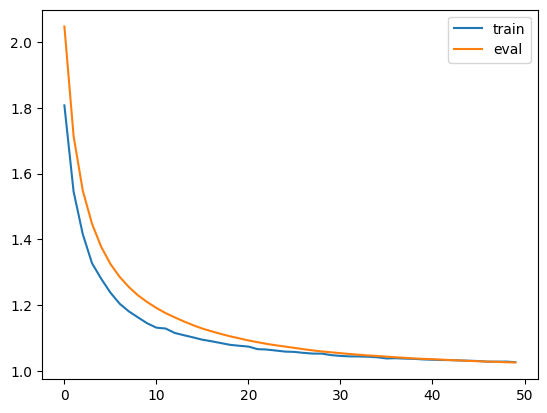

In [26]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label = 'train') 
plt.plot(eval_losses, label = 'eval') 
plt.legend()